# homework 4: bootstrapping

In [1]:
#Kingsley Chukwu HW_4

using DataFrames
using CSV
using PyPlot
using Random
using StatsBase
using Statistics

# (optional) change the style. see styles here: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("bmh")                                    
                                                                                  
# (optional) change settings for all plots at once, e.g. I like larger font size                           
rcParams = PyPlot.PyDict(PyPlot.matplotlib.rcParams)                           
rcParams["font.size"] = 16

# (optional) change the max width of columns of `DataFrame`
#  that are displayed in the Juptyer Notebook.
ENV["COLUMNS"] = 300 # characters

300

## bicycle rentals

You own a popular bicycle rental company near the Golden Gate Bridge that operates during the summer only. Hundreds of people rent your bicycles each day to ride over the Golden Gate bridge and around the park, and then they return their rented bicycle. To assess your inventory for a future surge in demand, you want to know the average duration that people rent your bicycles. Because it is too tedious to record the exact times that *every* bicycle (i.e. the entire population of bicycle renters) was rented and returned, you instead select a random sample of renters over the summer and record the duration that they rented their bicycle. You also record the weather that day-- whether it was cool or hot-- because you are interested in if the weather affects the mean duration that bicycles are rented.

(1) In `bicycle_rides.csv`, each row corresponds to the rental and subsequent return of a bicycle. The `:duration` column gives the duration, in minutes, that the bicycle was rented. The `:weather` column tells us whether the day was hot or cool. Read in the CSV file as a `DataFrame`, `df`, and display only the first 5 rows.

In [2]:
df = CSV.read("bicycle_rides.csv", copycols=true)
first(df, 5)

,duration,weather
,Float64,String
1,55.5,cool
2,54.2,cool
3,4.4,cool
4,29.1,hot
5,45.1,hot


(2) how many rentals of bicycles are represented in this sample?

In [4]:
kc = length(df[:, :duration])
println("The number of bicycle rentals in the sample are $kc")

The number of bicycle rentals in the sample are 299


(3) use the `by` function to group by the weather on the day of the rental, find the number of bike rides in the data set that took place with that kind of weather, then assign this to be a new column `nb_rides`. i.e. create a new `DataFrame`:

```
   weather    nb_rides
     cool        x
     hot         y
```
where `x` and `y` are integers denoting the number of bicycle rentals in the sample during cool and hot days, respectively.

In [5]:
df_by_weathers = groupby(df, :weather)
cool_num = length(df_by_weathers[1][:,:weather])
hot_num = length(df_by_weathers[2][:,:weather])
weather = [df_by_weathers[1][1,:weather], df_by_weathers[2][1,:weather]]
nb_rides = [cool_num, hot_num]
df_nb_rides = DataFrame(weather=weather, nb_rides=nb_rides)
maximum(df[:,:duration])

200.1

(4) Make a data visualization that compares the empirical distribution of the duration of bike rides on cold vs. hot days.
* use one big plot with two panels
* plot on panel `i` the histogram of durations of bike rides when the weather is `weathers[i]` for `i=1:2` and `weathers = ["cool", "hot"]`
* the two panels should have an identical x- and y-axis scale for a fair comparison
* the two histograms should use the same bin placements/widths for a fair comparison
* label each panel with a title corresponding to whether the weather was cool or hot
* use x- and y-axis labels
* use the color blue for the histogram corresponding to cool days and red for hot days
* use a `for` loop to make the plot

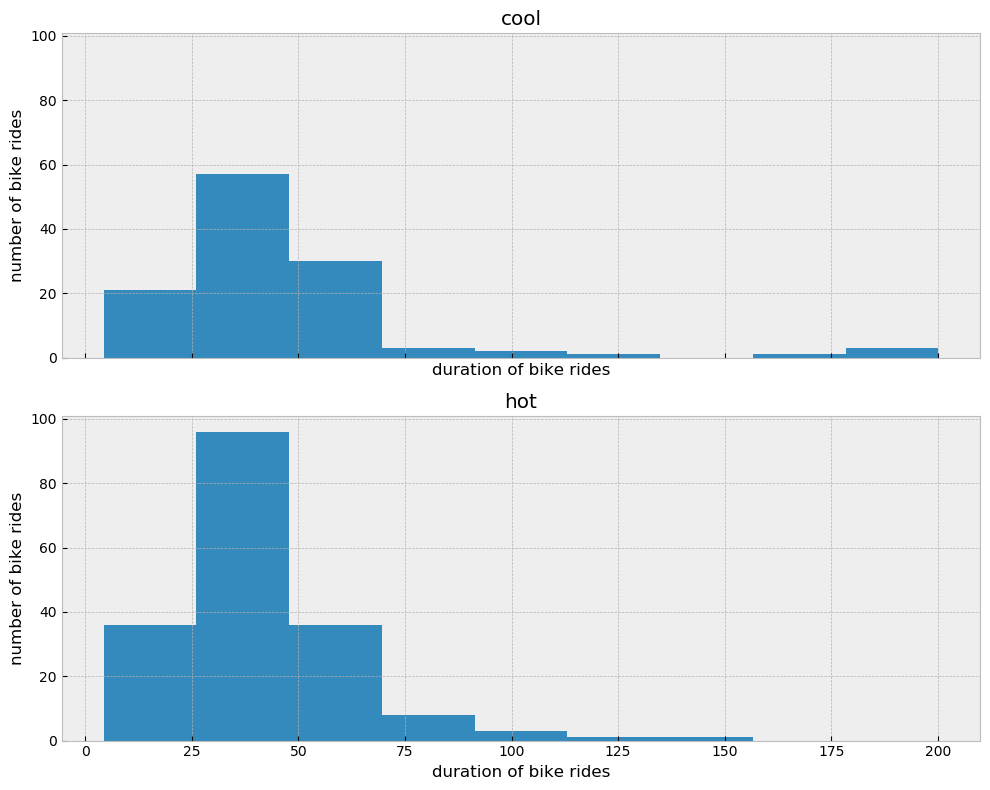

In [6]:
fig, axs = subplots(2, 1, figsize=(10, 8), 
                    sharex=true, sharey=true, tight_layout=true)
bins = range(minimum(df[:,:duration]), stop=maximum(df[:,:duration]), length = 10)

for (i, weather) in enumerate(["cool", "hot"])
    #some_random_numbers = rand(30)
    axs[i].hist(df_by_weathers[i][:,:duration], bins=bins)
    axs[i].set_ylabel("number of bike rides")
    axs[i].set_xlabel("duration of bike rides")
    axs[i].set_title(weather)
end


(5) does one distribution appear shifted to the right of the other? use the `by` function to group the `df` from (1) by weather, compute the mean duration of a bike ride in that kind of weather, and assign the result to be a new column `:mean_duration`. i.e. create a new `DataFrame`:

```
   weather    mean_duration
     cool        x
     hot         y
```
where `x` and `y` are floating points denoting the mean bicycle ride duration on cool and hot days, respectively.

In [25]:
mean_cool_num = mean(df_by_weathers[1][:,:duration])
mean_hot_num = mean(df_by_weathers[2][:,:duration])
weather = [df_by_weathers[1][1,:weather], df_by_weathers[2][1,:weather]]
mean_duration = [mean_cool_num, mean_hot_num]
df_mean_duration = DataFrame(weather=weather, mean_duration=mean_duration)

,weather,mean_duration
,String,Float64
1,cool,46.6712
2,hot,40.3066


(6) write a function `run_bootstrap` that takes in three arguments:
* `df::DataFrame` the entire bicycle rides `DataFrame` that you loaded in from (1)
* `weather::String` either "cool" or "warm"
* `nb_sims::Int` the number of times to draw a bootstrap sample to characterize the bootstrap empirical distribution of the sample mean duration of a bike ride = number of simulations of sampling the population

and does the following inside the function:

* creates a new `DataFrame`, `df_w`, with all the rows corresponding to bike rides taking place in `weather` weather.
* draws `nb_sims` bootstrap samples of bicycle rides in `weather` weather and computes the bootstrap sample mean of bicycle ride durations in `weather` weather. `df_w` will facilitate this. store these bootstrap sample means in an `Array{Float64}`
* return the array of the bootstrap sample means. this array is of length `nb_sims`.

test out your function by calling:
```julia
run_bootstrap(df, "cool", 100)
```
make sure you return an array of 100 (different) values that hover around the mean from (5).

In [35]:
function run_bootstrap(df::DataFrame, wea::String, nb_sims::Int)
    df_w = filter(row -> row[:weather] == wea, df)
    bootstrap_ave_duration = [NaN for s = 1:nb_sims]
    nb_samples = 60
    for s = 1:nb_sims
    # get id's of our random sample from our sample
      ids_of_bike_riders_sampled = sample(1:nb_samples, nb_samples, replace=true)
      sampled_duration = df_w[ids_of_bike_riders_sampled, :duration]
    # compute and store mean price of this bootstrap sample
      bootstrap_ave_duration[s] = mean(sampled_duration)
    end
    return bootstrap_ave_duration
end
#wea = "cool"
#df_w = filter(row -> row[:weather] == wea, df)

 bootstrap_ave=run_bootstrap(df, "cool", 100)

100-element Array{Float64,1}:
 47.72333333333334 
 48.063333333333325
 46.386666666666656
 45.33333333333333 
 44.133333333333326
 49.53             
 44.785            
 43.709999999999994
 49.115            
 43.64333333333334 
 54.40166666666666 
 50.81833333333335 
 42.40666666666665 
  ⋮                
 49.355            
 50.074999999999996
 38.61000000000001 
 51.37166666666666 
 42.855000000000004
 39.46333333333334 
 48.923333333333325
 47.308333333333344
 48.55499999999999 
 44.404999999999994
 47.44333333333334 
 40.61500000000001 

(7) write a function `confidence_interval` that takes in the following arguments:
* `bootstrap_means::Array{Float64}`: an array of bootstrap sample means that is output from `run_bootstrap` above.
* `confidence::Float64`: the desired confidence level, e.g. 95.0 for a 95% confidence level.

and returns a two-element array giving the interval estimate for the mean bicycle duration in a certain type of weather.

test your function by, e.g.:
```julia
bootstrap_means = run_bootstrap(df, "cool", 100)
ci = confidence_interval(bootstrap_means, 95.0) # returns [42.2, 53.4] but will differ from run to run 
```

In [54]:
function confidence_interval(bootstrap_means::Array{Float64,1}, confidence::Int64)
    interval = [NaN for s = 1:2]
    low_duration_estimate = percentile(bootstrap_means, (100-confidence))
    high_duration_estimate = percentile(bootstrap_means, confidence)
    interval[1] = low_duration_estimate
    interval[2] = high_duration_estimate
    return interval
end

confidence_interval(bootstrap_ave, 95)

2-element Array{Float64,1}:
 39.27625         
 51.92941666666667

(8) use your `run_bootstrap` and `confidence_interval` functions to, finally:
* visualize the bootstrap empirical distribution of the sample mean bicycle ride duration in each type of weather (for cool, hot weather) in two different panels much like in (4). again, the scales on the x- and y-axes should be the identical for a fair comparison.
* plot as a vertical line the sample mean bicycle ride duration in that type of weather
* highlight, as we did in lecture, the 95% confidence interval on the x-axis of the two panels, corresponding to the interval estimate for the mean bicycle ride duration in that type of weather. hint: `plot(ci, [0, 0], lw=6)` where `lw` is for line width.
* use the color blue for lines/bars in the "cool" weather panel and the color red for the "hot" weather panel. I think it looks nice if you use `alpha=0.3` for the histograms and non-transparent colors for the vertical line/confidence interval.

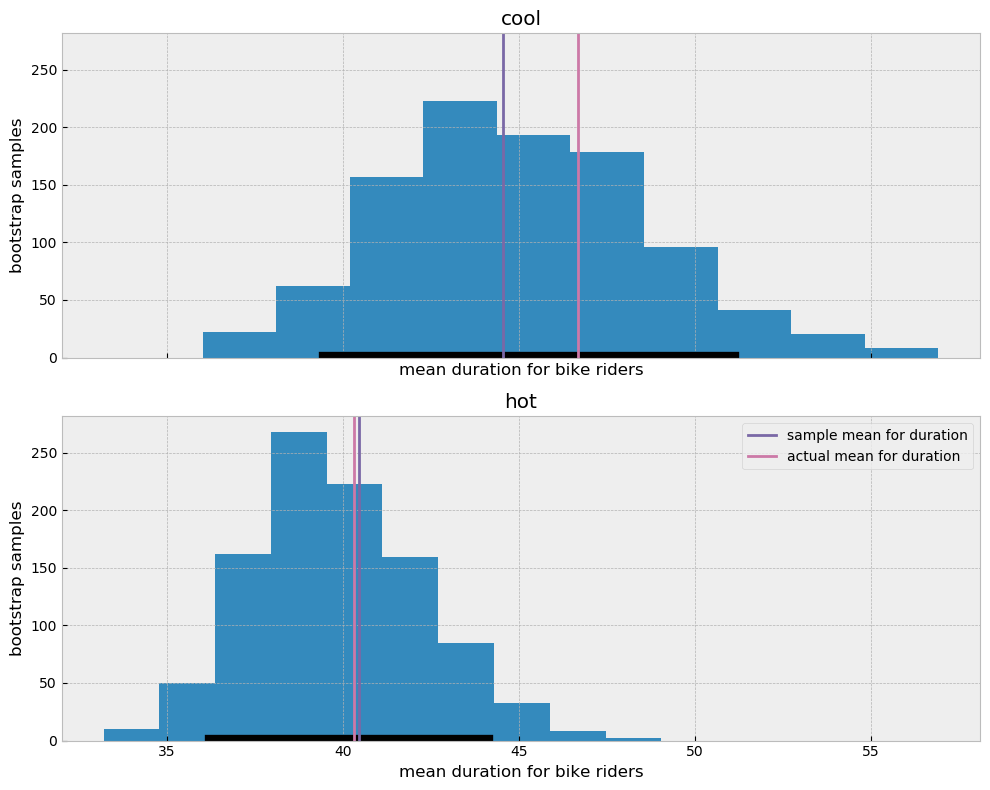

No handles with labels found to put in legend.


In [67]:
fig, axs = subplots(2, 1, figsize=(10, 8), 
                    sharex=true, sharey=true, tight_layout=true)

#bins = range(minimum(df[:,:duration]), stop=maximum(df[:,:duration]), length = 10)

for (i, weather) in enumerate(["cool", "hot"])
    ave_bootstrap = run_bootstrap(df, weather, 1000)
    inter = confidence_interval(ave_bootstrap, 95)
    nb_samples = 60
    ids_of_duration_sample = sample(1:nrow(df_by_weathers[i]), nb_samples, replace=false)
    sampled_duration = df_by_weathers[i][ids_of_duration_sample, :duration]
    estimate_mean = mean(sampled_duration)
    actual_mean = mean(df_by_weathers[i][:, :duration])
    axs[i].hist(ave_bootstrap)
    axs[i].plot([inter[1], inter[2]], [1, 1], color="k", lw=6)
    axs[i].axvline(x=estimate_mean, color="C2", label="sample mean for duration")
    axs[i].axvline(x=actual_mean, color="C5", label="actual mean for duration")
    axs[i].set_ylabel("bootstrap samples")
    axs[i].set_xlabel("mean duration for bike riders")
    axs[i].set_title(weather)
    legend()
end


(9) the width of the bootstrap empirical distribution of the sample mean bicycle ride duration is wider in one type of weather than the other... can you explain this? A wider width in the cool signifies that there is a lot more variation on the duration of bike rider in cool weather when compared to the hot weather. 

#(10) judging from the 95% confidence intervals, what do you think would be the outcome of a permutation test of the following two hypotheses with a significance level of $\alpha=0.05$?

**null hypothesis**: the mean duration of a bicycle ride on a hot day is 40 min

**alternative hypothesis**: the mean duration of a bicycle ride on a hot day is not 40 min

Choose one answer:<br>
(a) null hypothesis rejected<br>
(b) fail to reject the null hypothesis<br>
(c) I can't tell you from looking at my plot from (8), I'd have to actually do the permutation test to be sure.

A helpful resource for answering this: "Using a Confidence Interval to Test Hypotheses" [here](https://www.inferentialthinking.com/chapters/13/4/Using_Confidence_Intervals.html).
 
Answer : (C) I cannot tell you from looking at my plot from (8), I would have to actually do the permutation test to be sure            

(10) judging from the 95% confidence intervals, what do you think would be the outcome of a permutation test of the following two hypotheses with a significance level of $\alpha=0.05$?

**null hypothesis**: there is no difference in the mean duration of a bicycle ride on a hot vs. cool day

**alternative hypothesis**: the mean bicycle ride duration is higher on a cool day than a hot day.

Choose one answer:<br>
(a) null hypothesis rejected<br>
(b) fail to reject the null hypothesis<br>
(c) I can't tell you from looking at my plot from (8), I'd have to actually do the permutation test.

A helpful resource for answerin this: [this](https://core.ac.uk/download/pdf/82702323.pdf) and [this](https://blog.minitab.com/blog/real-world-quality-improvement/common-statistical-mistakes-you-should-avoid).
 
Answer : (C) I cannot tell you from looking at my plot from (8), I would have to actually do the permutation test to be sure
            

### etymology for curious readers

[bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping)